<a href="https://colab.research.google.com/github/lualua0909/DeepLearning-LDS8/blob/main/Week_3/RNN_%26_LSTM_Ex1_One_to_one_international_airline_passengers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Cho dữ liệu international-airline-passengers.csv.
* Xây dựng model để dự đoán số hành khách cho thời gian tiếp theo
* Giải thích cách tính tham số từ summary của model

In [104]:
# LSTM for international airline passengers problem with regression framing
import numpy
import matplotlib.pyplot as plt
import math
import pandas as pd
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [105]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    #t
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    #t+1
    dataY.append(dataset[i + look_back, 0])
  return numpy.array(dataX), numpy.array(dataY)

In [106]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [107]:
# load the dataset
dataframe = pd.read_csv('https://raw.githubusercontent.com/lualua0909/DeepLearning-LDS8/main/Data/international-airline-passengers.csv',
usecols=[1], engine='python')
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   passengers_in_thousands  144 non-null    int64
dtypes: int64(1)
memory usage: 1.2 KB


In [108]:
dataset = dataframe.values
dataset = dataset.astype('float32')
dataset[:10]

array([[112.],
       [118.],
       [132.],
       [129.],
       [121.],
       [135.],
       [148.],
       [148.],
       [136.],
       [119.]], dtype=float32)

In [109]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [110]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [111]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [112]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [113]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


**Giải thích cách tính tham số**
* lstm_1 (LSTM) = [(num_units + input_dim + 1) x num_units] x 4 = [(4 + 1 + 1) x 4] x 4 = 96
* dense_1 = ((current layer n x previous layer n) + bias) = 1 x 4 + 1 = 5

In [114]:
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=100, batch_size=32, verbose=0)

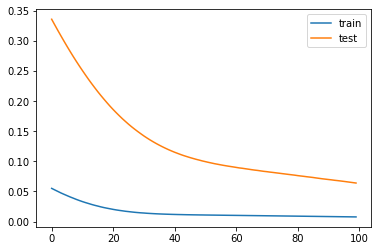

In [115]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [116]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [117]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [118]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 45.20 RMSE
Test Score: 130.93 RMSE


In [119]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

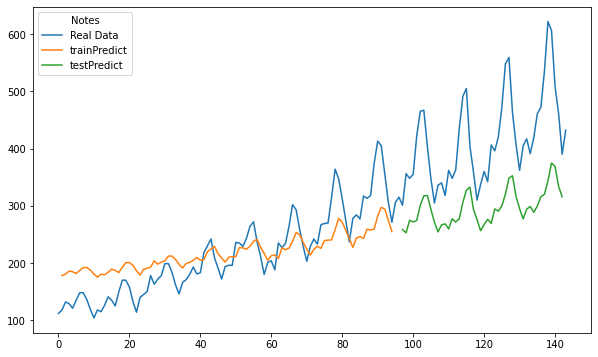

In [120]:
# plot baseline and predictions
plt.figure(figsize=(10,6))
plt.plot(scaler.inverse_transform(dataset), label='Real Data')
plt.plot(trainPredictPlot, label='trainPredict')
plt.plot(testPredictPlot, label='testPredict')
plt.legend(title="Notes")
plt.show()

In [121]:
ws = {}
for layer in model.layers:
  ws[layer.name] = layer.get_weights()
ws

{'dense_7': [array([[ 0.3609515],
         [ 0.8189932],
         [-1.0437462],
         [-1.2790859]], dtype=float32), array([0.07015616], dtype=float32)],
 'lstm_7': [array([[-0.2664764 ,  0.40828496,  0.4151788 ,  0.45422256,  0.05685246,
          -0.44251135, -0.26932994, -0.24858141,  0.689617  , -0.2117344 ,
          -0.45464417, -0.48788318,  0.4683929 ,  0.19376956,  0.12185384,
           0.09492896]], dtype=float32),
  array([[ 0.24742007,  0.07763102, -0.05387004, -0.12341242, -0.26896125,
           0.14450337,  0.08789206, -0.50391227,  0.04714735, -0.5015641 ,
           0.03062449,  0.27541372,  0.28550893, -0.3381222 ,  0.17855467,
          -0.03803244],
         [ 0.01645892,  0.03337638, -0.11554278,  0.37489647, -0.09811411,
           0.06033869,  0.32195422, -0.2372933 , -0.2920908 ,  0.5642393 ,
          -0.24156335,  0.13740732,  0.29034   ,  0.02584569,  0.18091804,
          -0.26995313],
         [ 0.03245952, -0.22881323, -0.04709362,  0.33053347, -0.5140

In [122]:
# x_new = 432 => next time = ?
x_new = scaler.transform([[432]])
x_new = numpy.reshape(x_new, (1, 1, 1))
y_new = model.predict(x_new)
y_new = scaler.inverse_transform(y_new)
y_new

array([[304.63318]], dtype=float32)

**Với lượng dữ liệu ít, bài toán này hoạt độnng chưa được tốt.**